In [39]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm

from urllib.parse import urlencode
import requests

In [40]:
# Функция для скачивания файла по переданной ссылке с яндекс диска
def download_file(ref, sep=';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=ref))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)    
    file = pd.read_csv(download_url, sep=sep)
    return file

In [41]:
# Загруэаем файлы с яндекс диска 
groups = download_file('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
checks = download_file('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
active_stud = download_file('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', sep=',')

In [42]:
# ЗАДАНИЕ №1
# Делаем полную таблицу с активными студентами, в которой будет информация об их оплатах и о принадлежности к определенной группе
full_active_stud = active_stud.merge(checks, how = 'left', on='student_id').merge(groups, left_on='student_id', right_on='id')
full_active_stud['paying_students'] = full_active_stud['rev'] > 0

# Создаем датафрейм только для платящих студентов 
# Обьединяем таблицу активных студентов с таблицей оплат только для тех id, по которым была оплата
paying_users = active_stud.merge(checks, how = 'inner', on='student_id').merge(groups, left_on='student_id', right_on='id')
    # Подсчет конверсий и общего количества студентов для каждой группы
    
group_stats = full_active_stud.groupby('grp').agg({
        'paying_students': 'sum',  # Количество конверсий
        'id': 'count'         # Общее количество студентов
    })
    # Переименовываем столбцы для ясности
group_stats.columns = ['paying_students', 'total_students']
    
    # Рассчитываем CR
group_stats['CR'] = group_stats['paying_students'] / group_stats['total_students']
    # Рассчитываем ARPPU
arppu = paying_users.groupby('grp').apply(lambda x: x['rev'].sum() / x['id'].nunique())
group_stats['ARPPU'] = arppu
group_stats

,paying_students,total_students,CR,ARPPU
grp,,,,
A,78,1535,0.050814,933.589744
B,313,6793,0.046077,1255.827487


In [43]:
#  ПЕРВОЙ МЕТРИКОЙ ВЫБИРАЕМ КОЭФФИЦИЕНТ КОНВЕРСИИ В ДВУХ ГРУППАХ
# Формулируем гипотезы 
# Н0 - конверсии в группах не отличаются
# Н1 - конверсии в группах различааются
group_A_paid =  group_stats.paying_students[0] # Количество платящих студентов в группе А
group_A_total = group_stats.total_students[0]  # Общее количество студентов в группе А
group_B_paid = group_stats.paying_students[1] # Количество платящих студентов в группе B
group_B_total = group_stats.total_students[1]   # Общее количество студентов в группе B

# Коэффициенты конверсии
p_A = group_A_paid / group_A_total
p_B = group_B_paid / group_B_total

# Общее количество студентов
n_A = group_A_total
n_B = group_B_total

# Общее количество платящих студентов
p_pooled = (group_A_paid + group_B_paid) / (n_A + n_B)

# Стандартная ошибка разности пропорций
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_A + 1/n_B))

# Z-статистика
z = (p_A - p_B) / se

# p-значение
p_value = 2 * (1 - norm.cdf(np.abs(z)))

print(f"Z-статистика: {z:.3f}")
print(f"p-значение: {p_value:.3f}")

# Интерпретация результата
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Результат статистически значимый: конверсии в группах отличаются.")
else:
    print("Результат статистически не значимый: конверсии в группах не отличаются.")
    
#  ВЫВОД: РАЗЛИЧИЕ В КОЭФФИЦИЕНТАХ КОНВЕРСИИ В ДВУХ ГРУППАХ СТАТИСТИЧЕСКИ НА ЗНАЧИМО. 
# НА ОСНОВЕ ДАННОЙ МЕТРИКИ НЕЛЬЗЯ СДЕЛАТЬ ВЫВОД ОБ ЭФФЕКТИВНОСТИ НОВЫЙ МЕХАНИКИ ОПЛАТЫ УСЛУГ

Z-статистика: 0.792
p-значение: 0.428
Результат статистически не значимый: конверсии в группах не отличаются.


[Text(0, 0.5, 'revenue'),
 Text(0.5, 0, 'group'),
 Text(0.5, 1.0, 'Revenue by group')]

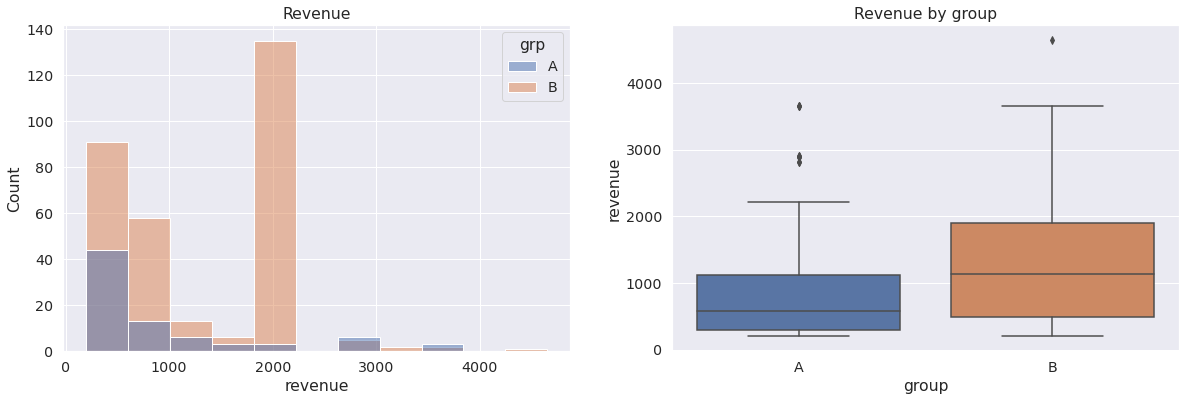

In [72]:
# Устанавливаем настройки графиков
sns.set(font_scale = 1.3, rc={'figure.figsize':(20,6)})
fig, ax = plt.subplots(nrows=1, ncols=2)

#  Строим гистограмму суммы оплат по группам
sns.histplot(data=full_active_stud, x=full_active_stud.rev, hue="grp", ax=ax[0])
ax[0].set(xlabel='revenue',title='Revenue')

# Строим боксплот, визуальна видно разницу между двумя группами

sns.boxplot(data=full_active_stud, x="grp", y="rev", ax=ax[1])
ax[1].set(xlabel='group', ylabel='revenue', title='Revenue by group')

In [46]:
# Второй метрикой выбираем ARPPU - средний сумму трат каждого активного пользователя в каждой группе
# Активным считается пользователь, который совершил оплату.
# Так как на гистограмме видно, что траты студентов  в обеих группах не подчиняются нормальному распределению,
# будем применять непараметрический тест Манна-Уитни

# Формулируем гипотезы
# Н0-распределения в группах не различаются
# Н1 - распределения в группах статистически значимо различаются

statistic, p_value = stats.mannwhitneyu(paying_users.query('grp=="B"').rev, paying_users.query('grp=="A"').rev, alternative='two-sided')
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Результат статистически значимый: распределения в группах отличаются.")
else:
    print("Результат статистически не значимый: распределения в группах не отличаются.")

#  ВЫВОД: НОВАЯ МЕХАНИКА СТАТИСТИЧЕСКИ ЗНАЧИМО УВЕЛИЧИВАЕТ СРЕДНИЙ ЧЕК. СТОИТ ПРИМЕНИТЬ ЕЕ НА ВСЕХ ПОЛЬЗОВАТЕЛЕЙ.

Результат статистически значимый: распределения в группах отличаются.


In [48]:
#  Несмотря на несоответствие распределений нормальному виду и учитывая большой обьем выборок,
# дополнительно можно провести ттест. p-value меньше 5%, значит различия между группами статистически значимы
statistic, p_value = stats.ttest_ind(paying_users.query('grp=="B"').rev, paying_users.query('grp=="A"').rev)

alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Результат статистически значимый: средние в группах отличаются.")
else:
    print("Результат статистически не значимый: средние в группах не отличаются.")
# Т-тест показываем аналогичную ситуацию. Средние в двух группах статистически значимо отличаются.

Результат статистически значимый: средние в группах отличаются.


In [73]:
# ЗАДАНИЕ №2

# Подключаемся к базе данных default в Clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [74]:
# Запрос на получение количества прилежных студентов, у которых больше 20 верно решенных заданий
query = """
select count(distinct st_id) as count_smart_students from peas
where st_id in (
    select st_id from peas
    group by st_id
    having sum(correct) > 20
)
"""
df = ph.read_clickhouse(query, connection=connection)
df

,count_smart_students
0,130


In [75]:
# Запрос на получение ARPU, ARPAU, CR, CR_ACTIVE, CR_ACTIVE_MATH
query = """
WITH user_activity AS (
--Для каждого пользователя находим общее количество решенных задач, а также общее количество решенных задач по математике
    SELECT
        st_id,
        SUM(CASE WHEN correct = 1 THEN 1 ELSE 0 END) AS total_correct,
        SUM(CASE WHEN correct = 1 AND subject = 'Math' THEN 1 ELSE 0 END) AS math_correct
    FROM
        peas
    GROUP BY
        st_id
),
-- Список активных пользователей, у которых больше 10 правильно решенных задач
active_users AS (
    SELECT
        st_id
    FROM
        user_activity
    WHERE
        total_correct > 10
),
-- Список активных пользователей по математике, у которых больше 2 правильно решенных задач по математике
active_math_users AS (
    SELECT
        st_id
    FROM
        user_activity
    WHERE
        math_correct >= 2
),
-- Для каждого пользователя, принадлежащего какой либо группе, находим количество потраченных денег 
combined AS (
    SELECT
        s.st_id,
        s.test_grp,
        f.subject subject,
        COALESCE(f.money, 0) AS money
    FROM
        studs s
    LEFT JOIN
        final_project_check f ON s.st_id = f.st_id
),
aggregated AS (
    SELECT
        test_grp,
        COUNT(DISTINCT c.st_id) AS total_users, --Общее количество пользователей в каждой группе
        COUNT(DISTINCT CASE WHEN c.money > 0 THEN c.st_id END) AS paying_users, -- КОличество платящих пользователей в каждой группе
        COUNT(DISTINCT CASE WHEN c.money > 0 THEN a.st_id END) as paying_active_users, --Количество платящих активных пользователей в каждой группе
        COUNT(DISTINCT CASE WHEN c.money > 0 and c.subject='Math' THEN a_math.st_id END) as paying_active_math_users, --КОличество платящих активных 
        SUM(COALESCE(c.money, 0)) AS total_revenue, --Общая выручка по каждой группе
        COUNT(DISTINCT a.st_id) AS active_users, --Общее количество активных пользователей в каждой группее
        COUNT(DISTINCT a_math.st_id) AS active_math_users --Общее количество активных пользователей по математике в каждой группе
    FROM
        combined c
    LEFT JOIN
        active_users a ON c.st_id = a.st_id
    LEFT JOIN
        active_math_users a_math ON c.st_id = a_math.st_id
    GROUP BY
        test_grp
),
metrics AS 
(
    SELECT
        test_grp,
        total_users,
        paying_users,
        total_revenue,
        -- ARPU: Средний доход на пользователя
        total_revenue / NULLIF(total_users, 0) AS ARPU,
        -- ARPAU: Средний доход на активного пользователя
        total_revenue / NULLIF(active_users, 0) AS ARPAU,
        -- CR: Конверсионный коэффициент (доля платящих пользователей)
        paying_users  / total_users CR,
        -- CR: Конверсионный коэффициент (доля активных пользователей в покупку)
        paying_active_users / active_users CR_active,
        -- CR: Конверсионный коэффициент (доля активных пользователей в покупку курса по математике)
        paying_active_math_users / active_math_users CR_active_math
    FROM
        aggregated
)
select 
    test_grp,
    ARPU,
    ARPAU,
    CR,
    CR_active,
    CR_active_math
from metrics
"""

df = ph.read_clickhouse(query, connection=connection)
df

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.983607,10820.3125,0.049180,0.117188,0.080000
1,pilot,11508.474576,35000.0000,0.108475,0.268041,0.116279


In [76]:
# ЗАДАНИЕ №3
def func1(groups, checks, active_studs):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://yadi.sk/d/5Kxrz02m3IBUwQ'  # Сюда вписываете вашу ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)

    # Чтение CSV файла из ссылки
    groups_add = pd.read_csv(download_url)

    # Добавляем столбец активности студентов
    active_studs['active'] = 1

    # Переименование столбца для объединения
    checks = checks.rename(columns={'student_id': 'id'})
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    # Объединение групп и переименование столбца
    shared_group = pd.concat([groups, groups_add]).rename(columns={'grp': 'group'})

    # Объединение активных студентов и платежей
    active_checks = active_studs.merge(checks, on='id', how='left').rename(columns={'rev': 'revenue'})

    # Финальное объединение данных
    general_file = shared_group.merge(active_checks, on='id', how='left').fillna(0)

    # Фильтрация только активных студентов
    general_file_active = general_file.query('active==1')

    # Отбор групп А и Б среди платящих пользователей
    group_A = general_file_active.query('group == "A" and revenue > 0')
    group_B = general_file_active.query('group == "B" and revenue > 0')
    # Расчет метрик
    CR_A = round(group_A.id.count() / general_file_active.query('group == "A"').id.count(), 4)
    CR_B = round(group_B.id.count() / general_file_active.query('group == "B"').id.count(), 4)
    ARPPU_A = round(group_A.revenue.sum() / group_A.id.count(), 2)
    ARPPU_B = round(group_B.revenue.sum() / group_B.id.count(), 2)


    # Создание таблицы с метриками
    metrics = pd.DataFrame({
                'group': ['A', 'B'], 
                'total_sum': [group_A.revenue.sum(), group_B.revenue.sum()],
                'count_users': [general_file_active.query('group=="A"').id.count(),
                                general_file_active.query('group=="B"').id.count()],
                'count_customers': [group_A.id.count(), group_B.id.count()],
                'CR': [CR_A, CR_B],
                'ARPPU': [ARPPU_A, ARPPU_B]
            })
    return metrics

In [77]:
func1(groups, checks, active_stud)

,group,total_sum,count_users,count_customers,CR,ARPPU
0,A,72820.0000,1538,78,0.0507,933.59
1,B,394974.0035,6803,314,0.0462,1257.88


In [78]:
# Пишем функцию для автоматического построения графиков по метрикам

def do_graphs(data):
    #  Устанавливаем размер шрифта на графикам
    sns.set(font_scale = 1.2, rc={'figure.figsize':(16,4)})
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    # Строим график для CR
    sns.barplot(data=data, x='group', y = 'CR', ax=ax[0])
    ax[0].set(xlabel = '', ylabel= '', title = 'CR')
    
    # Строим график для ARPPU
    sns.barplot(data=data, x='group', y = 'ARPPU', ax=ax[1])
    ax[1].set(xlabel = '', ylabel= '', title = 'ARPPU')
    plt.show()

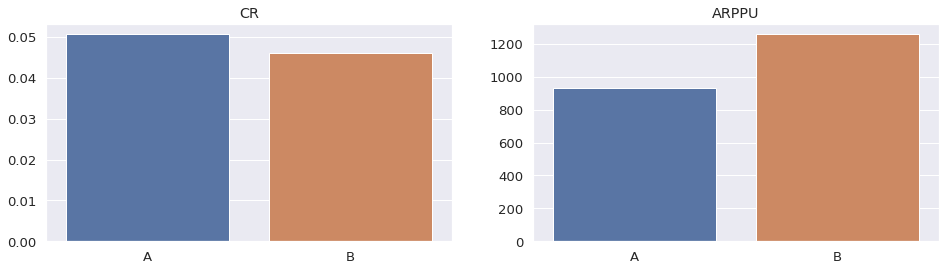

In [79]:
do_graphs(func1(groups, checks, active_stud))